In [2]:
%pip install torch torchvision opencv-python matplotlib numpy



Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt 
import random
import uuid
from tqdm import tqdm
import numpy as np 
from PIL import Image


# set device to "mps", "cuda:0" if on cuda, or just "cpu"

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)


mps


# Dataset

In [7]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform = None):

        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        # tuple contains img_path and number of person 
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        get_same_person = random.randint(0,1) 
        if get_same_person:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]: # if the number of the person is the same (img_tuple[1]), then we have found a photo of the same person 
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:  # if the number of the person is different (img_tuple[1]), then we have found a photo of a different person
                    break

        img0 = Image.open(img0_tuple[0]) #read the image from the file path
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L") #convert to grayscale
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        
        return len(self.imageFolderDataset)



### Load dataset from [dataHacker's GitHub](https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip)

In [5]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

UnboundLocalError: local variable 'child' referenced before assignment

# The Neural Net

Based on design from image on [Branislav Holländer's Medium blogpost](https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18)

In [9]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_one_image(self, x):
        
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        
        output1 = self.forward_one_image(input1)
        output2 = self.forward_one_image(input2)

        return output1, output2

net = SiameseNetwork().to(device)

In [8]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive


In [10]:
# Load the training dataset
training_dataset_folder = ImageFolder(root="./data/faces/training/")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])

training_dataset = SiameseNetworkDataset(imageFolderDataset=training_dataset_folder,
                                        transform=transformation)


('./data/faces/training/s2/9.pgm', 11)


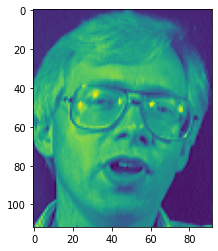

In [26]:
# see format in which random.choice retreives random images 
test = random.choice(training_dataset_folder.imgs)

# Returns (img_path, person_number)

print(test)

test_image = Image.open(test[0])

plt.imshow(test_image)

Epoch number 0
 Current loss 0.5362119674682617

Epoch number 1
 Current loss 0.4507067799568176

Epoch number 2
 Current loss 0.32568860054016113

Epoch number 3
 Current loss 0.3257947862148285

Epoch number 4
 Current loss 0.3978554606437683

Epoch number 5
 Current loss 0.4642205238342285

Epoch number 6
 Current loss 0.3349830210208893

Epoch number 7
 Current loss 0.4073636531829834

Epoch number 8
 Current loss 0.38532543182373047

Epoch number 9
 Current loss 0.2161705195903778

Epoch number 10
 Current loss 0.34033671021461487

Epoch number 11
 Current loss 0.23241056501865387

Epoch number 12
 Current loss 0.3332135081291199

Epoch number 13
 Current loss 0.28651419281959534

Epoch number 14
 Current loss 0.1396285593509674

Epoch number 15
 Current loss 0.1511024385690689

Epoch number 16
 Current loss 0.19118571281433105

Epoch number 17
 Current loss 0.29543960094451904

Epoch number 18
 Current loss 0.15635661780834198

Epoch number 19
 Current loss 0.24280010163784027

E

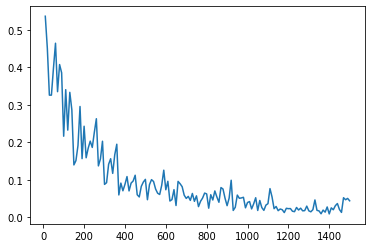

In [ ]:
BATCH_SIZE = 64
train_dataloader = DataLoader(training_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=BATCH_SIZE)



criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
EPOCHS = 150

# used to plot loss with iterations
counter = []
loss_history = [] 
iteration_number= 0


# Iterate throught the epochs
for epoch in range(EPOCHS):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Zero the gradients
        optimizer.zero_grad()

        # Send the images and labels to device

        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

    
plt.plot(counter, loss_history)
plt.show()


# Save model for use in the FaceID App

In [ ]:
torch.save(net.state_dict(), "faceid_siamese_network.pth")
    